In [28]:
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import pixiedust
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 4000

/media/DATA/serbulent/anaconda3/envs/embedding_similarity/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


In [29]:
def create_index_from_model_name(index_names):
    index_list = []
    for index_name in index_names:
        new_name = index_name.split("_")[1:len(index_names)]
        new_name = '_'.join(new_name)
        index_list.append(new_name)
    return index_list

In [30]:
#Read prediction results and order them alphabetically. Hence they are ordered by aspect.
def create_pred_table(measure):
    path = '/media/DATA/serbulent/DATA/Thesis/ReviewPaper/results/revision-1/function_prediction/'

    go_pred_table = pd.DataFrame()
    for filename in sorted(glob.glob(os.path.join(path, '*_5cv_mean.tsv'))):
            col_name = filename.split("Ontology_based_function_prediction")[-1].split("_")[1]

            tmp_column = pd.read_csv(filename,sep="\t")
            tmp_column.sort_values(tmp_column.columns[0])

            go_pred_table[col_name] = tmp_column[measure]
            index = create_index_from_model_name(list(tmp_column.iloc[:, 0]))

    go_pred_table["index_col"] = index
    go_pred_table.set_index('index_col', inplace=True)
    go_pred_table.sort_index(inplace=True)
    return go_pred_table

In [31]:
# Slice dataframe by aspect and order subgroups
def get_go_pred_table_for_aspect(aspect,go_pred_table):
    if aspect == "BP":
        go_pred_tableBP = go_pred_table[0:9]
        new_index =  ["BP_High_Shallow", "BP_High_Normal", "BP_High_Specific",\
                      "BP_Middle_Shallow","BP_Middle_Normal","BP_Middle_Specific",\
                      "BP_Low_Shallow","BP_Low_Normal","BP_Low_Specific"]
        go_pred_tableBP = go_pred_tableBP.reindex(new_index)
        return go_pred_tableBP
    if aspect == "CC":
        go_pred_tableCC = go_pred_table[9:17]
        new_index =  ["CC_High_Shallow", "CC_High_Normal",\
                      "CC_Middle_Shallow","CC_Middle_Normal","CC_Middle_Specific",\
                      "CC_Low_Shallow","CC_Low_Normal","CC_Low_Specific"]
        go_pred_tableCC = go_pred_tableCC.reindex(new_index)
        return go_pred_tableCC
    if aspect == "MF":
        go_pred_tableMF = go_pred_table[17:25]
        new_index =  ["MF_High_Shallow", "MF_High_Normal",\
                      "MF_Middle_Shallow","MF_Middle_Normal","MF_Middle_Specific",\
                      "MF_Low_Shallow","MF_Low_Normal","MF_Low_Specific"]
        go_pred_tableMF = go_pred_tableMF.reindex(new_index)
        return go_pred_tableMF


In [32]:
#draw a grouped bar chart for results
def drawBenchmarks(dataset,embedding_lables,title):
    cols = ["Accuracy","F1_Weighted"]
    colors=['peachpuff', 'palegreen','lightskyblue', 'orange']
    edgecolor="violet"
    bar_width = .8

    ax = dataset[cols].plot.bar(width=bar_width\
                                  , ylim=[-0.2, 1], color=colors,figsize=(12,8),edgecolor=edgecolor)

    #get first 4 label
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels[0:4])
    ax.set_title('Prediction Benchmark for ' + title )
    ax.set_xticklabels(embedding_lables)
    ax.set_xlabel('')

In [33]:
#Calculate mean measures for different aspects also return F1 weigted scores
def prepare_figure_data_for_aspect(aspect):
    go_pred_tableF1 = create_pred_table("F1_Weighted")
    go_pred_tableACC = create_pred_table("Accuracy")
    go_pred_tablePR = create_pred_table("Precision_Weighted")
    go_pred_tableREC = create_pred_table("Recall_Weighted")
    go_pred_tableHAMM = create_pred_table("Hamming_Distance")

    go_pred_tableF1_aspect = get_go_pred_table_for_aspect(aspect,go_pred_tableF1)
    go_pred_tableACC_aspect = get_go_pred_table_for_aspect(aspect,go_pred_tableACC)
    go_pred_tablePR_aspect = get_go_pred_table_for_aspect(aspect,go_pred_tablePR)
    go_pred_tableREC_aspect = get_go_pred_table_for_aspect(aspect,go_pred_tableREC)
    go_pred_tableHAMM_aspect = get_go_pred_table_for_aspect(aspect,go_pred_tableHAMM)

    go_pred_tableF1_aspect_mean = go_pred_tableF1_aspect.mean(axis = 0)
    go_pred_tableACC_aspect_mean = go_pred_tableACC_aspect.mean(axis = 0) 
    go_pred_tablePR_aspect_mean = go_pred_tablePR_aspect.mean(axis = 0) 
    go_pred_tableREC_aspect_mean = go_pred_tableREC_aspect.mean(axis = 0)
    go_pred_tableHAMM_aspect_mean = go_pred_tableHAMM_aspect.mean(axis = 0)

    new_index =  ["Accuracy","F1-Weighted","Precision","Recall", "Hamming"]
    pred_mean_df = pd.DataFrame([go_pred_tableACC_aspect_mean])
    pred_mean_df = pred_mean_df.append(go_pred_tableF1_aspect_mean, ignore_index=True)
    pred_mean_df = pred_mean_df.append(go_pred_tablePR_aspect_mean, ignore_index=True)
    pred_mean_df = pred_mean_df.append(go_pred_tableREC_aspect_mean, ignore_index=True)
    pred_mean_df = pred_mean_df.append(go_pred_tableHAMM_aspect_mean, ignore_index=True)
    pred_mean_df = pred_mean_df.set_index(pd.Series(new_index))
    
    display_labels = ['InterPro2GO','UniRule2GO','Ensembl-Orthology','BLAST','HMMER','K-Sep','APAAC','PFAM','AAC','ProtVec',\
    'Gene2Vec','Learned-Vec','Mut2Vec','TCGA-Embedding','SeqVec','MSA-Transformer','CPCProt','ProtBERT-BFD',\
    'TAPE-BERT-PFAM','ESM-1b','ProtALBERT','ProtXLNet','UniRep','ProtT5-XL']
    
    columnsTitles = ['INTERPRO2GO','UNIRULE2GO','ENSEMBL-ORTHOLOGY','BLAST','HMMER','K-SEP','APAAC','PFAM','AAC','PROTVEC',\
    'GENE2VEC','LEARNED-VEC','MUT2VEC','TCGA-EMBEDDING','SEQVEC','MSA-Transformer','CPC-PROT','BERT-BFD',\
    'BERT-PFAM','ESMB1','ALBERT','XLNET','UNIREP','T5']
    
    pred_mean_df = pred_mean_df.reindex(columns=columnsTitles)
    go_pred_tableF1_aspect = go_pred_tableF1_aspect.reindex(columns=columnsTitles)
    go_pred_tablePR_aspect = go_pred_tablePR_aspect.reindex(columns=columnsTitles)
    
    pred_mean_df.columns = display_labels
    go_pred_tableF1_aspect.columns = display_labels
    go_pred_tablePR_aspect.columns = display_labels
    
    return pred_mean_df,go_pred_tableF1_aspect,go_pred_tablePR_aspect

In [34]:
#Create dataframes for figures
pred_mean_df_BP, go_pred_tableF1_BP,go_pred_tablePR_Precision_BP = prepare_figure_data_for_aspect("BP")
pred_mean_df_CC, go_pred_tableF1_CC,go_pred_tablePR_Precision_CC = prepare_figure_data_for_aspect("CC")
pred_mean_df_MF, go_pred_tableF1_MF, go_pred_tablePR_Precision_MF= prepare_figure_data_for_aspect("MF")

In [35]:
pred_mean_df_MF.T.to_csv("/media/DATA/serbulent/DATA/Thesis/ReviewPaper/results/revision-1/pred_mean_df_MF.csv")
pred_mean_df_BP.T.to_csv("/media/DATA/serbulent/DATA/Thesis/ReviewPaper/results/revision-1/pred_mean_df_BP.csv")
pred_mean_df_CC.T.to_csv("/media/DATA/serbulent/DATA/Thesis/ReviewPaper/results/revision-1/pred_mean_df_CC.csv")

In [36]:
def get_category_based_average_results(tables):
    categories = {}

    categories["Low"] = ["BP_Low_Shallow","BP_Low_Normal","BP_Low_Specific","CC_Low_Shallow",\
                   "CC_Low_Normal","CC_Low_Specific","MF_Low_Shallow","MF_Low_Normal","MF_Low_Specific" ]
    categories["Middle"] = ["BP_Middle_Shallow","BP_Middle_Normal","BP_Middle_Specific","CC_Middle_Shallow",\
                   "CC_Middle_Normal","CC_Middle_Specific","MF_Middle_Shallow","MF_Middle_Normal","MF_Middle_Specific" ]
    categories["High"] = ["BP_High_Shallow","BP_High_Normal","BP_High_Specific","CC_High_Shallow",\
                   "CC_High_Normal","MF_High_Shallow","MF_High_Normal"]
    
    categories["Specific"] = ["BP_High_Specific","BP_Middle_Specific","BP_Low_Specific","CC_Middle_Specific",\
                        "CC_Low_Specific","MF_Middle_Specific","MF_Low_Specific"]
    categories["Normal"] = ["BP_High_Normal","BP_Middle_Normal","BP_Low_Normal","CC_High_Normal","CC_Middle_Normal",\
                        "CC_Low_Normal","MF_High_Normal","MF_Middle_Normal","MF_Low_Normal"] 
    categories["Shallow"] = ["BP_High_Shallow","BP_Middle_Shallow","BP_Low_Shallow","CC_High_Shallow","CC_Middle_Shallow",\
                        "CC_Low_Shallow","MF_High_Shallow","MF_Middle_Shallow","MF_Low_Shallow"]
    
    '''search_list = []
    if result_type == "low":
        search_list = low_results
    if result_type == "specific":
        search_list = specific_results'''
    averaged_aspect_tables = {}
    for table_aspect in list(tables.keys()):
        averaged_category_sr_list = []
        for category in list(categories.keys()):
            category_list = categories[category]
            category_elements = [category_element for category_element in category_list\
                                 if table_aspect in category_element]
            #print(category_elements)
            
            df = tables[table_aspect]
            averaged_category_sr = df[df.index.isin(category_elements)].mean(axis = 0)#.to_frame()
            #print(averaged_category_sr)
            averaged_category_sr_list.append(averaged_category_sr)
        result = pd.concat(averaged_category_sr_list,axis=1,keys=list(categories.keys()))
        result['Average'] = result.mean(axis=1)
        result = result.sort_values(by='Average', ascending=False)
        averaged_aspect_tables[table_aspect] = result
    
    return averaged_aspect_tables

In [37]:
tables = {}
tables["MF"] = go_pred_tableF1_MF
tables["BP"] = go_pred_tableF1_BP
tables["CC"] = go_pred_tableF1_CC

In [38]:
cat_based_avg_dict = get_category_based_average_results(tables)
path = "/media/DATA/serbulent/DATA/Thesis/ReviewPaper/results/revision-1/"
for table_aspect in list(tables.keys()):
    cat_based_avg_dict[table_aspect].to_csv(path+"category_based_average_"+table_aspect+".csv")

In [39]:
cat_based_avg_dict

{'MF':                         Low    Middle      High  Specific    Normal   Shallow  \
 ProtT5-XL          0.886067  0.906947  0.915760  0.916125  0.931810  0.860960   
 HMMER              0.894427  0.893650  0.881070  0.916495  0.913410  0.851050   
 SeqVec             0.857007  0.905663  0.898960  0.912635  0.908197  0.845357   
 ProtALBERT         0.859133  0.899460  0.903895  0.890860  0.896360  0.870923   
 BLAST              0.855443  0.893143  0.876670  0.896285  0.914663  0.820847   
 PFAM               0.853173  0.863350  0.882860  0.840195  0.889947  0.855020   
 ProtBERT-BFD       0.818100  0.856620  0.880630  0.852385  0.848893  0.844657   
 TAPE-BERT-PFAM     0.830023  0.861790  0.848720  0.857985  0.868307  0.817330   
 ESM-1b             0.803910  0.847060  0.852985  0.854845  0.887963  0.761767   
 UniRep             0.846767  0.796597  0.827685  0.861750  0.865917  0.754737   
 ProtXLNet          0.788043  0.824720  0.843980  0.838625  0.839327  0.777007   
 K-Sep    

In [40]:
pred_mean_df_MF.loc['F1-Weighted'].sort_values()

UniRule2GO           0.011459
Ensembl-Orthology    0.199461
TCGA-Embedding       0.343855
InterPro2GO          0.371516
AAC                  0.409741
Gene2Vec             0.531127
Mut2Vec              0.573119
APAAC                0.582846
ProtVec              0.636666
CPCProt              0.654452
MSA-Transformer      0.666220
Learned-Vec          0.675541
K-Sep                0.809005
ProtXLNet            0.815781
UniRep               0.823182
ESM-1b               0.832360
TAPE-BERT-PFAM       0.846610
ProtBERT-BFD         0.848178
PFAM                 0.864411
BLAST                0.874888
ProtALBERT           0.885446
SeqVec               0.885741
HMMER                0.890796
ProtT5-XL            0.901320
Name: F1-Weighted, dtype: float64

In [41]:
pred_mean_df_BP.loc['F1-Weighted'].sort_values()

UniRule2GO           0.011506
InterPro2GO          0.112134
AAC                  0.187196
Ensembl-Orthology    0.240556
TCGA-Embedding       0.320514
APAAC                0.344661
ProtVec              0.362433
Learned-Vec          0.391669
CPCProt              0.395483
Mut2Vec              0.427092
Gene2Vec             0.438548
MSA-Transformer      0.471013
UniRep               0.479462
ProtXLNet            0.499628
K-Sep                0.516863
ESM-1b               0.533279
TAPE-BERT-PFAM       0.535141
BLAST                0.555932
PFAM                 0.557242
SeqVec               0.600279
HMMER                0.611008
ProtBERT-BFD         0.611577
ProtALBERT           0.625530
ProtT5-XL            0.655843
Name: F1-Weighted, dtype: float64

In [42]:
pred_mean_df_CC.loc['F1-Weighted'].sort_values()

UniRule2GO           0.038385
AAC                  0.232186
Ensembl-Orthology    0.262632
InterPro2GO          0.269393
ProtVec              0.380771
APAAC                0.395269
Learned-Vec          0.408931
TCGA-Embedding       0.411886
CPCProt              0.435190
Mut2Vec              0.461644
Gene2Vec             0.501628
K-Sep                0.502334
MSA-Transformer      0.503270
UniRep               0.532510
BLAST                0.573139
PFAM                 0.580642
TAPE-BERT-PFAM       0.581110
ProtXLNet            0.587796
HMMER                0.595703
SeqVec               0.606451
ESM-1b               0.609787
ProtBERT-BFD         0.622095
ProtALBERT           0.635540
ProtT5-XL            0.680294
Name: F1-Weighted, dtype: float64

In [43]:
#Classic Representations: Yellow
#Learned Small Scale Models: Blue
#Learned Large Scale Models: Red
group_color_dict = {'InterPro2GO':'orange','UniRule2GO':'orange','Ensembl-Orthology':'orange',\
                    'K-Sep':'green','TAPE-BERT-PFAM':'red', 'UniRep':'red', 'ProtT5-XL':'red', 'ProtBERT-BFD':'red',\
 'HMMER':'green', 'SeqVec':'red','MSA-Transformer':'red', 'ProtALBERT':'red', 'BLAST':'green', 'PFAM':'green', 'ESM-1b':'red', \
 'ProtXLNet':'red', 'AAC':'green', 'APAAC':'green', 'ProtVec':'blue', 'Mut2Vec':'blue',\
'Learned-Vec':'blue', 'CPCProt':'blue', 'Gene2Vec':'blue', 'TCGA-Embedding':'blue'}

def set_colors_and_marks_for_representation_groups(ax):
    for label in ax.get_xticklabels():
        label.set_color(group_color_dict[label.get_text()])
        lt = label.get_text()
        if  lt == 'Mut2Vec' or lt =='PFAM' or lt == 'Gene2Vec' or lt == 'TAPE-BERT-PFAM':
            signed_text = "^" + label.get_text()
            label.set_text(signed_text)
    fontproperties = {'weight' : 'bold'}
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties)

In [44]:
go_pred_tableF1_MF

,InterPro2GO,UniRule2GO,Ensembl-Orthology,BLAST,HMMER,K-Sep,APAAC,PFAM,AAC,ProtVec,...,SeqVec,MSA-Transformer,CPCProt,ProtBERT-BFD,TAPE-BERT-PFAM,ESM-1b,ProtALBERT,ProtXLNet,UniRep,ProtT5-XL
index_col,,,,,,,,,,,,,,,,,,,,,
MF_High_Shallow,0.277898,0.020900,0.296182,0.84964,0.84565,0.69092,0.41431,0.85595,0.26868,0.58882,...,0.85771,0.72079,0.61797,0.83441,0.79589,0.78616,0.87193,0.80014,0.73787,0.88731
MF_High_Normal,0.090229,0.008656,0.106369,0.90370,0.91649,0.88485,0.82855,0.90977,0.83960,0.83729,...,0.94021,0.84813,0.86338,0.92685,0.90155,0.91981,0.93586,0.88782,0.91750,0.94421
MF_Middle_Shallow,0.736221,0.005315,0.300635,0.92355,0.91231,0.82433,0.54760,0.91300,0.37717,0.62191,...,0.91837,0.72947,0.63533,0.87619,0.85521,0.81686,0.91479,0.85675,0.75523,0.90851
MF_Middle_Normal,0.619354,0.008583,0.348647,0.93553,0.91898,0.82660,0.52414,0.88293,0.37269,0.53791,...,0.89295,0.70238,0.57429,0.87285,0.86210,0.87646,0.90465,0.81111,0.81263,0.90900
MF_Middle_Specific,0.064202,0.003269,0.100973,0.82035,0.84966,0.78086,0.38837,0.79412,0.31741,0.48407,...,0.90567,0.68962,0.62802,0.82082,0.86806,0.84786,0.87894,0.80630,0.82193,0.90333
MF_Low_Shallow,0.343710,0.011822,0.091166,0.68935,0.79519,0.72519,0.57283,0.79611,0.34138,0.56481,...,0.75999,0.32059,0.52361,0.82337,0.80089,0.68228,0.82605,0.67413,0.77111,0.78706
MF_Low_Normal,0.680704,0.028799,0.178513,0.90476,0.90476,0.83944,0.74603,0.87714,0.55619,0.79400,...,0.89143,0.57211,0.79749,0.74698,0.84127,0.86762,0.84857,0.81905,0.86762,0.94222
MF_Low_Specific,0.159810,0.004331,0.173202,0.97222,0.98333,0.89985,0.64094,0.88627,0.20481,0.66452,...,0.91960,0.74667,0.59553,0.88395,0.84791,0.86183,0.90278,0.87095,0.90157,0.92892


/media/DATA/serbulent/anaconda3/envs/embedding_similarity/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


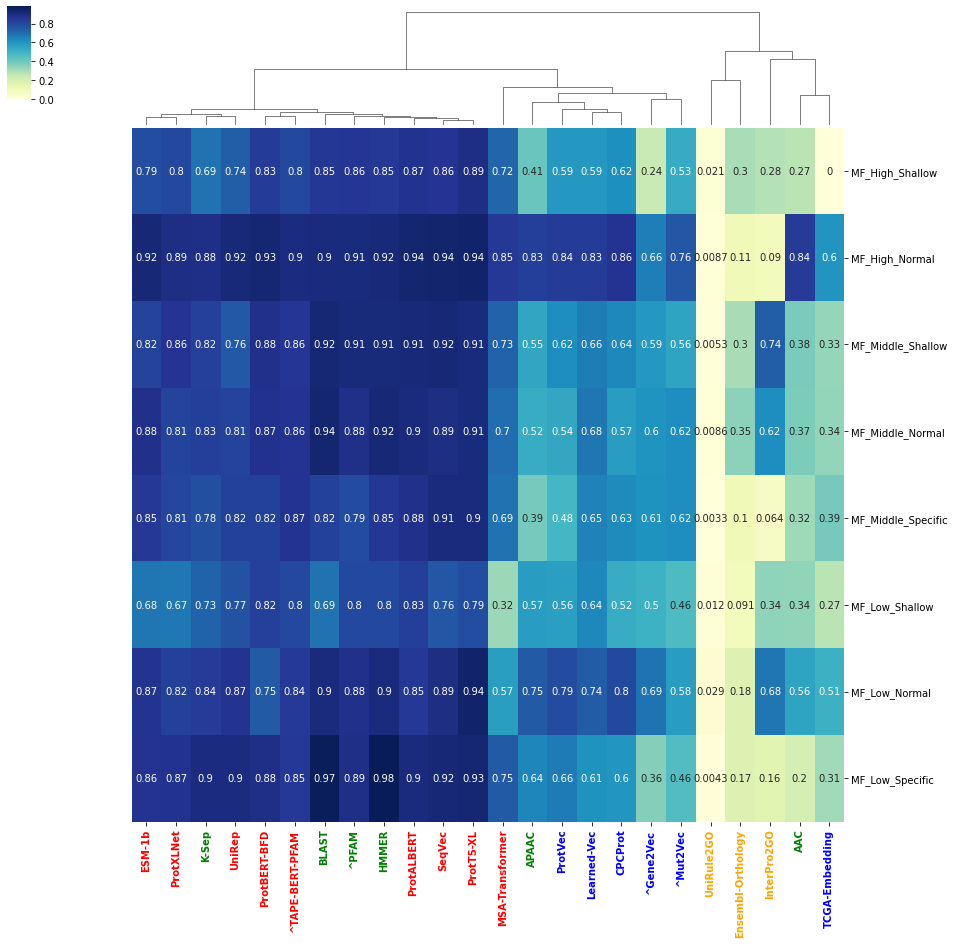

In [45]:
g = sns.clustermap(go_pred_tableF1_MF, annot=True, cmap="YlGnBu", row_cluster=False,figsize=(15, 15))
ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")
set_colors_and_marks_for_representation_groups(ax)
g.savefig('/media/DATA/serbulent/DATA/Thesis/ReviewPaper/results/revision-1/figures/func_pred_MF.eps', dpi=600)

/media/DATA/serbulent/anaconda3/envs/embedding_similarity/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


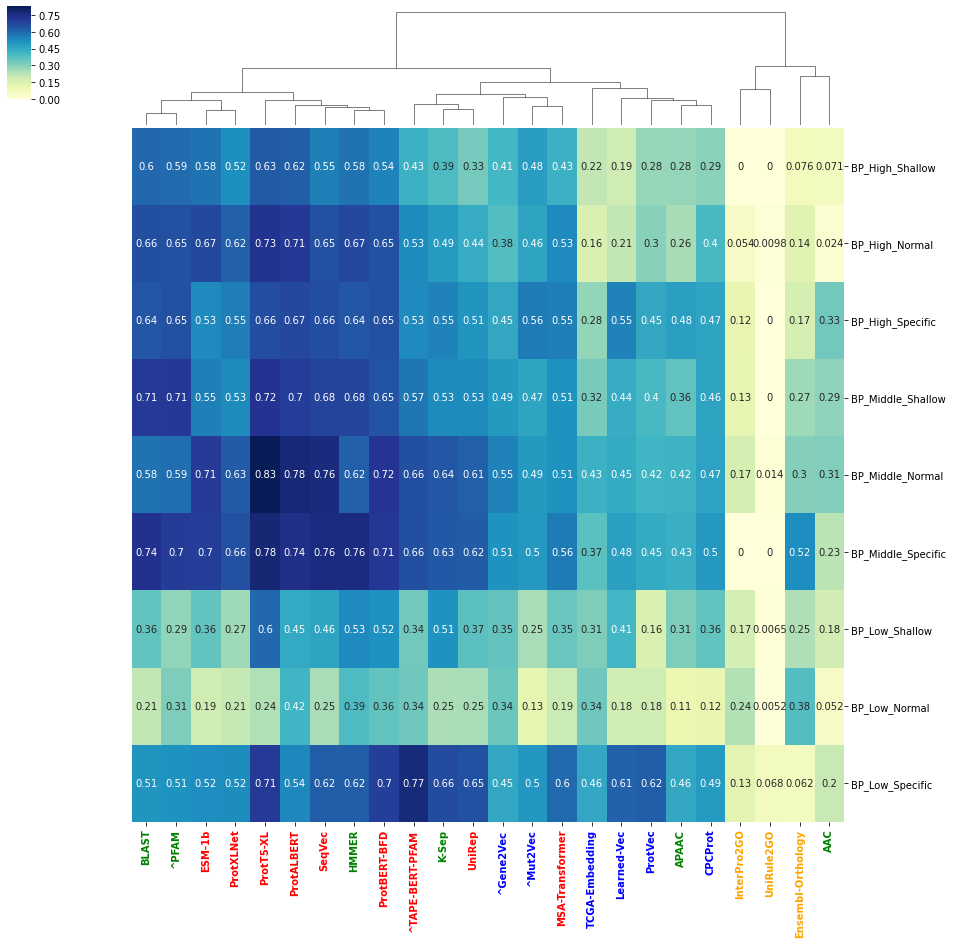

In [46]:
g = sns.clustermap(go_pred_tableF1_BP, annot=True, cmap="YlGnBu", row_cluster=False,figsize=(15, 15))
ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")
set_colors_and_marks_for_representation_groups(ax)
g.savefig('/media/DATA/serbulent/DATA/Thesis/ReviewPaper/results/revision-1/figures/func_pred_BP.eps', dpi=600)

/media/DATA/serbulent/anaconda3/envs/embedding_similarity/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


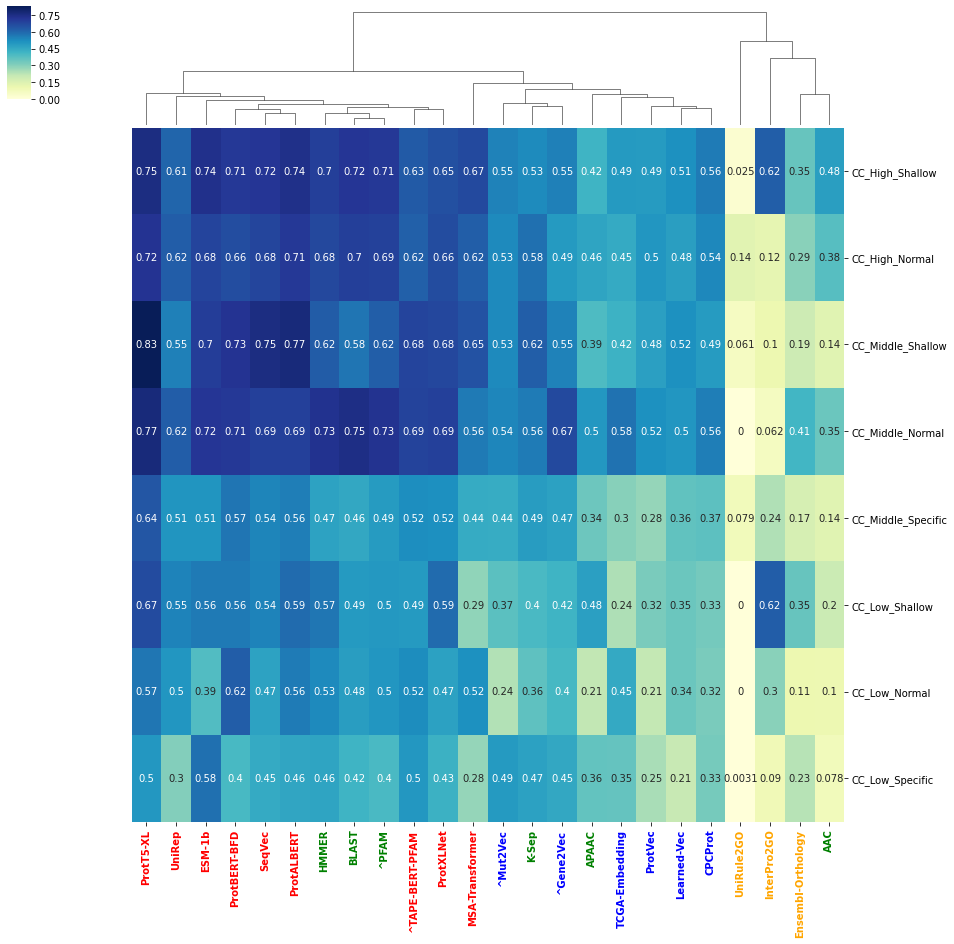

In [47]:
g = sns.clustermap(go_pred_tableF1_CC, annot=True, cmap="YlGnBu", row_cluster=False,figsize=(15, 15))
ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")
set_colors_and_marks_for_representation_groups(ax)
g.savefig('/media/DATA/serbulent/DATA/Thesis/ReviewPaper/results/revision-1/figures/func_pred_CC.eps', dpi=600)

# Precision based Results

In [21]:
pred_mean_df_MF.loc['Precision'].sort_values()

TCGA-Embedding       0.406137
AAC                  0.486701
UniRule2GO           0.537443
Gene2Vec             0.593219
Mut2Vec              0.626444
APAAC                0.674449
ProtVec              0.680556
CPCProt              0.704869
Learned-Vec          0.720504
MSA-Transformer      0.725977
ProtXLNet            0.847180
K-Sep                0.847999
TAPE-BERT-PFAM       0.859390
UniRep               0.859886
InterPro2GO          0.861345
ESM-1b               0.865328
ProtBERT-BFD         0.872693
Ensembl-Orthology    0.894138
SeqVec               0.908421
HMMER                0.911452
ProtALBERT           0.913290
BLAST                0.921949
ProtT5-XL            0.922379
PFAM                 0.929220
Name: Precision, dtype: float64

In [22]:
pred_mean_df_BP.loc['Precision'].sort_values()

UniRule2GO           0.185220
AAC                  0.322453
ProtVec              0.409817
TCGA-Embedding       0.416731
APAAC                0.422988
Learned-Vec          0.477393
Gene2Vec             0.492096
Mut2Vec              0.493110
InterPro2GO          0.496106
CPCProt              0.508447
MSA-Transformer      0.568432
K-Sep                0.593181
UniRep               0.596241
ProtXLNet            0.612028
TAPE-BERT-PFAM       0.612468
ESM-1b               0.641249
HMMER                0.644752
SeqVec               0.647029
PFAM                 0.672381
BLAST                0.680741
ProtBERT-BFD         0.699581
ProtALBERT           0.706301
ProtT5-XL            0.712681
Ensembl-Orthology    0.715068
Name: Precision, dtype: float64

In [23]:
pred_mean_df_CC.loc['Precision'].sort_values()

UniRule2GO           0.168804
AAC                  0.282926
APAAC                0.452484
ProtVec              0.452634
Learned-Vec          0.469528
TCGA-Embedding       0.495521
CPCProt              0.520679
Mut2Vec              0.528820
Gene2Vec             0.549860
K-Sep                0.581884
UniRep               0.588260
MSA-Transformer      0.592782
HMMER                0.645084
TAPE-BERT-PFAM       0.660314
ProtXLNet            0.667268
SeqVec               0.681702
ProtBERT-BFD         0.694099
BLAST                0.696880
ESM-1b               0.701250
PFAM                 0.712705
Ensembl-Orthology    0.716468
InterPro2GO          0.724810
ProtALBERT           0.725626
ProtT5-XL            0.756058
Name: Precision, dtype: float64

In [24]:
go_pred_tablePR_Precision_MF


,InterPro2GO,UniRule2GO,Ensembl-Orthology,BLAST,HMMER,K-Sep,APAAC,PFAM,AAC,ProtVec,...,SeqVec,MSA-Transformer,CPCProt,ProtBERT-BFD,TAPE-BERT-PFAM,ESM-1b,ProtALBERT,ProtXLNet,UniRep,ProtT5-XL
index_col,,,,,,,,,,,,,,,,,,,,,
MF_High_Shallow,0.982579,1.000000,0.900909,0.91405,0.86737,0.82714,0.59164,0.94403,0.52383,0.63865,...,0.87978,0.85840,0.77352,0.90541,0.80244,0.87770,0.89749,0.86549,0.82721,0.91894
MF_High_Normal,0.777767,0.769178,0.934377,0.91845,0.91979,0.93669,0.82134,0.91674,0.87365,0.85037,...,0.95076,0.89331,0.87945,0.92839,0.88749,0.90026,0.95685,0.95260,0.89962,0.94908
MF_Middle_Shallow,0.991983,0.188679,1.000000,0.92622,0.90396,0.86234,0.70004,0.95168,0.45613,0.64165,...,0.91524,0.81447,0.66886,0.90152,0.90337,0.90021,0.93843,0.86612,0.83511,0.93669
MF_Middle_Normal,0.922581,0.396456,0.962433,0.94454,0.91421,0.82425,0.58006,0.93605,0.50185,0.63841,...,0.91168,0.81940,0.66673,0.89893,0.86062,0.94230,0.93619,0.84059,0.83521,0.92885
MF_Middle_Specific,0.782146,0.600475,0.921680,0.96132,0.85070,0.82715,0.65098,0.94920,0.44639,0.57039,...,0.92487,0.74327,0.70234,0.85757,0.87652,0.87056,0.90966,0.82374,0.90702,0.90899
MF_Low_Shallow,0.433708,0.433708,0.433708,0.82625,0.93083,0.75000,0.56204,0.92852,0.30391,0.58792,...,0.84750,0.30528,0.50333,0.80070,0.80500,0.66889,0.85917,0.73769,0.77019,0.80727
MF_Low_Normal,1.000000,0.700980,1.000000,0.90476,0.90476,0.82587,0.71310,0.85754,0.57619,0.79762,...,0.88254,0.59452,0.77230,0.73254,0.84643,0.82659,0.84603,0.81309,0.84325,0.94921
MF_Low_Specific,1.000000,0.210066,1.000000,0.98000,1.00000,0.93055,0.77639,0.95000,0.21166,0.71944,...,0.95500,0.77917,0.67242,0.95648,0.89325,0.93611,0.96250,0.87812,0.96148,0.98000


/media/DATA/serbulent/anaconda3/envs/embedding_similarity/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


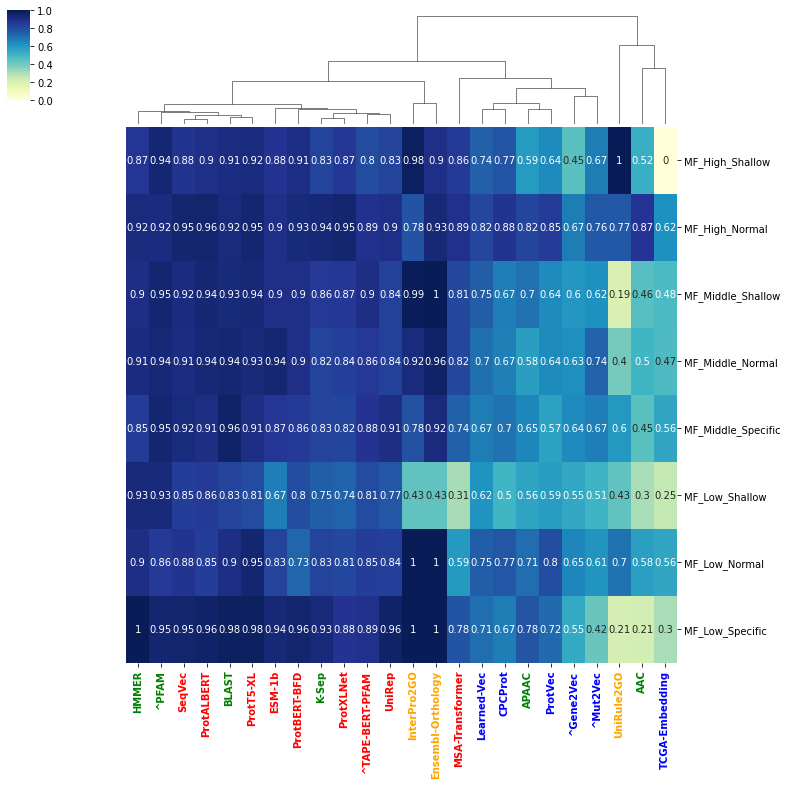

In [25]:
g = sns.clustermap(go_pred_tablePR_Precision_MF, annot=True, cmap="YlGnBu", row_cluster=False,figsize=(12, 12))
ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")
set_colors_and_marks_for_representation_groups(ax)

/media/DATA/serbulent/anaconda3/envs/embedding_similarity/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


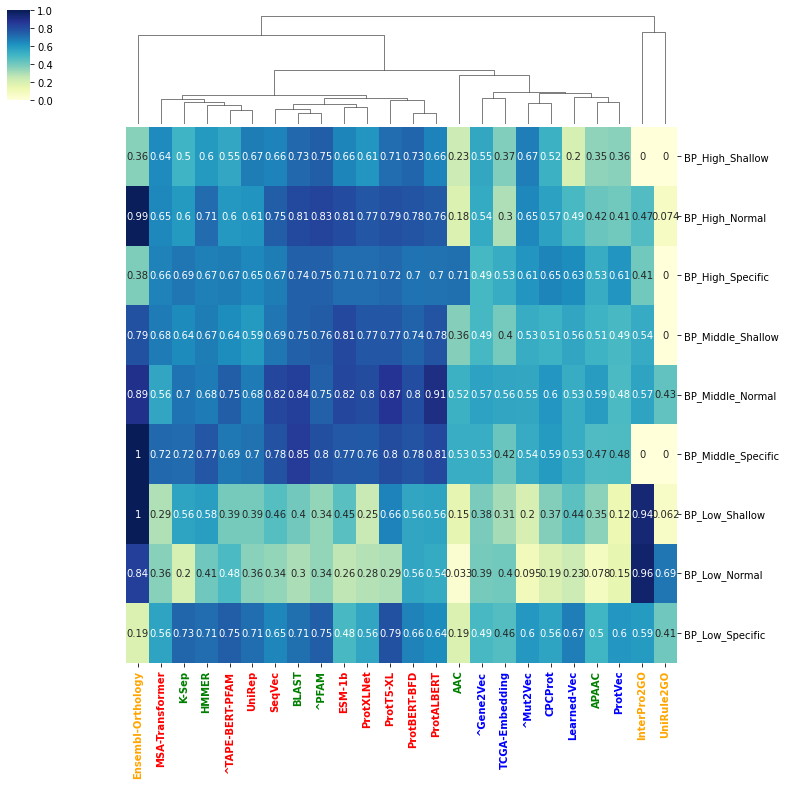

In [26]:
g = sns.clustermap(go_pred_tablePR_Precision_BP, annot=True, cmap="YlGnBu", row_cluster=False,figsize=(12, 12))
ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")
set_colors_and_marks_for_representation_groups(ax)

/media/DATA/serbulent/anaconda3/envs/embedding_similarity/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


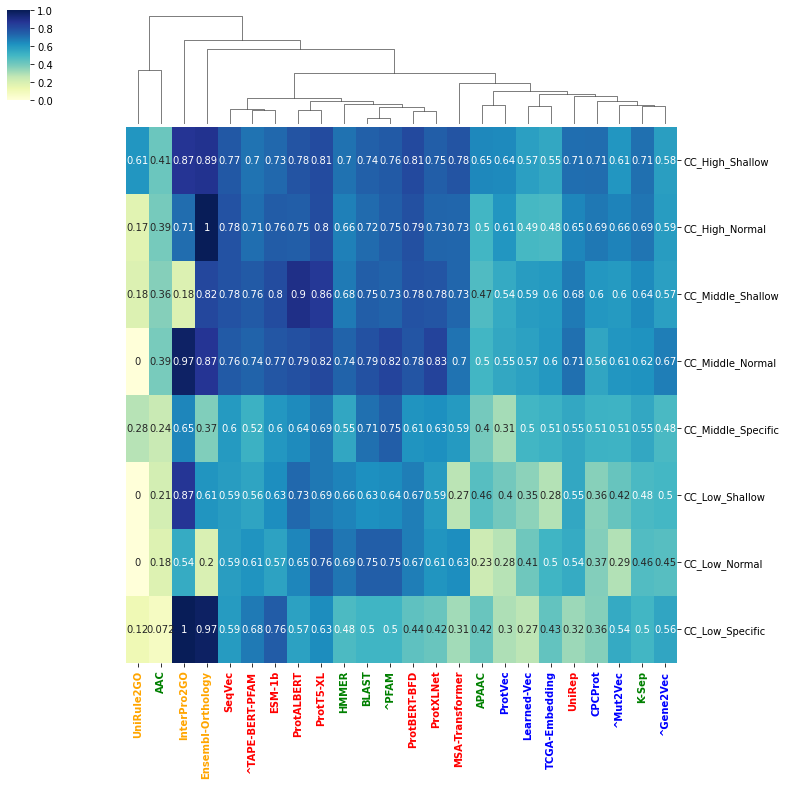

In [27]:
g = sns.clustermap(go_pred_tablePR_Precision_CC, annot=True, cmap="YlGnBu", row_cluster=False,figsize=(12, 12))
ax = g.ax_heatmap
ax.set_xlabel("")
ax.set_ylabel("")
set_colors_and_marks_for_representation_groups(ax)